In [409]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import block_diag

sys.path.append(os.path.abspath(os.path.join('../../src')))
sys.path.append(os.path.abspath(os.path.join('../newton_based_algorithms')))

from utils import get_form_initial_conditions
# try:
    # from tudatpy.astro.time_conversion import DateTime
    # use_tudatpy = True
# finally:
    # print('No tudatpy available')
    # use_tudatpy = False
use_tudatpy = False
from dynamics import SatelliteDynamics, Propagator

from unkkt import UNKKT
from tree_newton import Tree_Newton
from approxh_newton import approxH_Newton
from mm_newton import MM_Newton

# try: 
#     from concurrent.futures import ProcessPoolExecutor
#     use_several_cpus = True
# finally:
#     print('No concurrent.futures.ProcessPoolExecutor available')
#     use_several_cpus = False
from concurrent.futures import ProcessPoolExecutor
use_several_cpus = True

In [410]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 10  # Duration [min]

# Set simulation start (0 TDB seconds since J2000) and end epochs
if use_tudatpy:
    simulation_start_epoch = DateTime(2000, 1, 1).epoch()
    simulation_end_epoch = (T - 1) * dt

T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # State dimension
n_p = 3  
n_y_1 = 3 
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 5 # Window size [min]

In [411]:
# Initial state vector and get the true state vectors
X_initial = get_form_initial_conditions(formation)
if use_tudatpy:
    propagator = Propagator(simulation_start_epoch, simulation_end_epoch, dt, X_initial)
    X_true = propagator.run().T.reshape(24, 1, T)
else:
    X_true = np.zeros((24, 1, T))
    X_true[:, :, 0] = X_initial
    for t in range(T - 1):
        X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

In [412]:
if use_tudatpy:
    # Estimate process noise
    X_our_model = np.zeros((24, 1, T))
    X_our_model[:, :, 0] = X_initial
    for t in range(T - 1):
        X_our_model[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

    # Compute the difference between the ground truth and the model after initial conditions
    diff = X_true[:, :, 1:] - X_our_model[:, :, 1:]
    diff_flattened = diff.T.reshape(-1, 24)

    # Calculate the general covariance matrix of the flattened differences
    Q = np.cov(diff_flattened, rowvar=False)

    # Create a zero matrix of the same shape
    Q_modified = np.zeros_like(Q)

    # Fill only the required block diagonals
    Q_modified[:6, :6] = np.diag(np.diag(Q[:6, :6]))
    Q_modified[6:12, 6:12] = np.diag(np.diag(Q[6:12, 6:12]))
    Q_modified[12:18, 12:18] = np.diag(np.diag(Q[12:18, 12:18]))
    Q_modified[18:, 18:] = np.diag(np.diag(Q[18:, 18:]))
    Q = Q_modified
    pd.DataFrame(Q[:6, :6]), pd.DataFrame(Q[6:12, 6:12]), pd.DataFrame(Q[12:18, 12:18]), pd.DataFrame(Q[18:, 18:])

In [413]:
# propagator2 = Propagator(simulation_start_epoch, simulation_end_epoch, 1.0, X_initial)
# X_true2 = propagator2.run().T.reshape(24, 1, 23641)

# # Estimate process noise
# X_our_model2 = np.zeros((24, 1, 23641))
# X_our_model2[:, :, 0] = X_initial
# for t in range(23641 - 1):
#     X_our_model2[:, :, t + 1] = SatelliteDynamics().x_new(1.0, X_true2[:, :, t])

# # Compute the difference between the ground truth and the model after initial conditions
# diff2 = X_true2[:, :, 1:] - X_our_model2[:, :, 1:]
# diff_flattened2 = diff2.T.reshape(-1, 24)

# # Calculate the general covariance matrix of the flattened differences
# Q2 = np.cov(diff_flattened2, rowvar=False)

# # Create a zero matrix of the same shape
# Q_modified2 = np.zeros_like(Q2)

# # Fill only the required block diagonals
# Q_modified2[:6, :6] = np.diag(np.diag(Q2[:6, :6]))
# Q_modified2[6:12, 6:12] = np.diag(np.diag(Q2[6:12, 6:12]))
# Q_modified2[12:18, 12:18] = np.diag(np.diag(Q2[12:18, 12:18]))
# Q_modified2[18:, 18:] = np.diag(np.diag(Q2[18:, 18:]))
# Q2 = Q_modified2
# pd.DataFrame(Q2[:6, :6]), pd.DataFrame(Q2[6:12, 6:12]), pd.DataFrame(Q2[12:18, 12:18]), pd.DataFrame(Q2[18:, 18:])

In [414]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [415]:
tol = 1e-20
max_iter = 100

# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
# unkkt.grad_tol = tol
# unkkt.max_iter = max_iter

tree_newton = Tree_Newton(W, R_chief, r_deputy_pos)
# tree_newton.grad_tol = tol
# tree_newton.max_iter = max_iter

approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
# approxh_newton.grad_tol = tol
# approxh_newton.max_iter = max_iter

mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
# mm_newton.grad_tol = tol
# mm_newton.max_iter = max_iter
# mm_newton.mm_tol = tol
# mm_newton.mm_max_iter = 1

In [416]:
# Simulation setup
np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

Windows:   0%|          | 0/6 [00:00<?, ?it/s]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 165657577225693.7
Gradient norm: 21637148642.534527
Global relative error: 3640522.4330060305
Position relative errors: 1820348.2597387978 m, 1820351.4194822395 m, 1819943.1629051506 m, 1820397.5551868558 m

Before applying the algorithm
L_norm = 165657581017652.53
Grad_L_norm = 21637148654.646908

Before applying the algorithm
Cost function: 165657581017652.53
Gradient norm: 21637148654.646908
Global relative error: 3640522.4330060305
Position relative errors: 1820348.2597387978 m, 1820351.4194822395 m, 1819943.1629051506 m, 1820397.5551868558 m

Iteration 1
Cost function: 8693812913.267288 (-99.99%)
Gradient norm: 195062333.24955833 (-99.10%)
Global relative error: 5377.04562297515 (-99.85%)
Position relative errors: 3128.7626555997326 m, 3069.2050628755164 m, 2132.8991131435655 m, 2260.7697048171112 m

Iteration 1
L_norm = 8693823236.534231

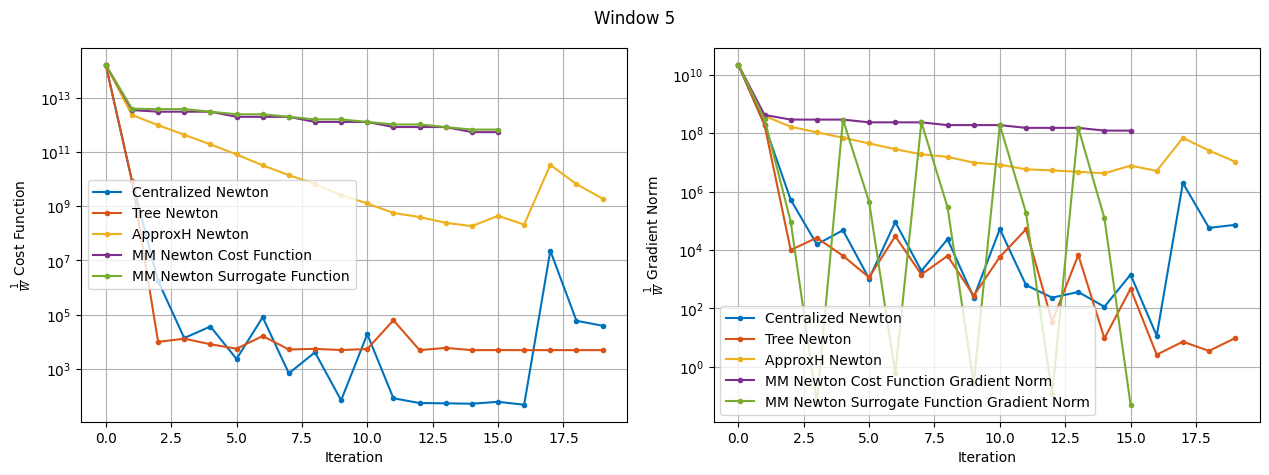


Windows:  17%|█▋        | 1/6 [00:04<00:22,  4.40s/it]

-------- Centralized Newton ---------------- Tree Newton --------

-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 11063.923372849296
Gradient norm: 26352.485378188005
Global relative error: 2500.718436757287
Position relative errors: 0.12356293865663492 m, 592.2767250859457 m, 1785.2611653957367 m, 1647.9074196605882 m

Before applying the algorithm
Cost function: 3606615659.1743445
Gradient norm: 14390356.530783977
Global relative error: 22605.5199902805
Position relative errors: 349.2879377117101 m, 9871.773613950756 m, 13483.383218099452 m, 15212.723269732944 m

Before applying the algorithm
L_norm = 74163.27160621862
Grad_L_norm = 100224.08020347617

Iteration 1
Cost function: 1713.3490628745974 (-84.51%)
Gradient norm: 23.36812253854696 (-99.91%)
Global relative error: 2406.941582245563 (-3.75%)
Position relative errors: 0.15268997134690054 m, 621.0361111440745 m, 1711.4244024979166 m, 1574.3809304551007 m

Iteration 1
Cost function: 1416542805.44456

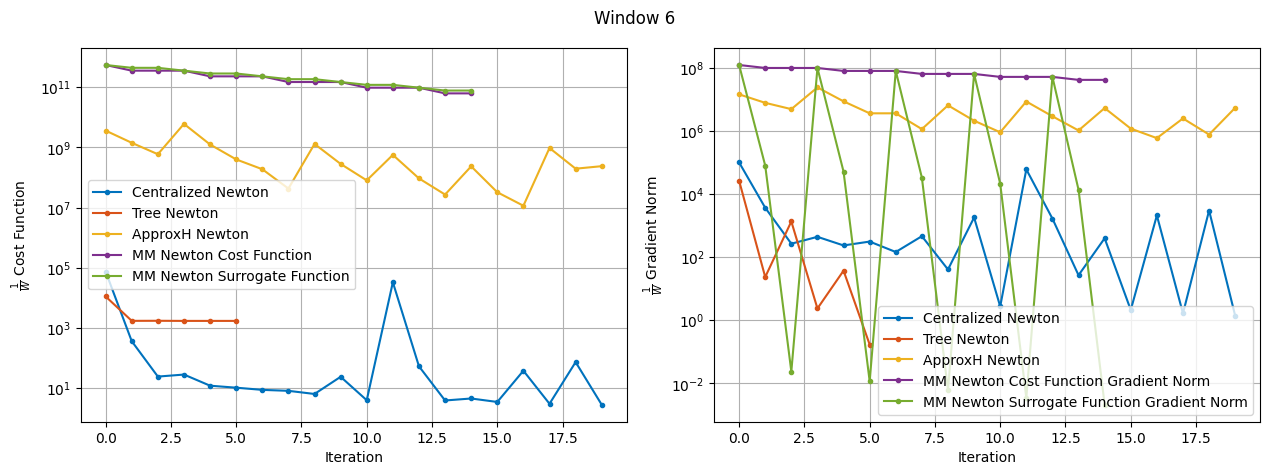


Windows:  33%|███▎      | 2/6 [00:07<00:14,  3.73s/it]

-------- Tree Newton ---------------- Centralized Newton --------

-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 380889644.2025921
Gradient norm: 7561364.454761899
Global relative error: 14548.976251189444
Position relative errors: 201.92506369692512 m, 9997.693185253967 m, 6609.571034515284 m, 8244.452852701139 m

Before applying the algorithm
Cost function: 3207.7592353109458
Gradient norm: 14296.409895359096
Global relative error: 2480.532688738298Before applying the algorithm
L_norm = 38.181374775754875
Grad_L_norm = 1408.2024376956028


Position relative errors: 0.08400606107019036 m, 558.1122085512998 m, 1751.419086727817 m, 1665.548549465679 m

Iteration 1
Cost function: 25194783.8408475 (-93.39%)
Gradient norm: 1238785.861101191 (-83.62%)
Global relative error: 10284.948170523821 (-29.31%)
Position relative errors: 120.82353517121403 m, 5846.564857814796 m, 6013.294789765725 m, 5950.982419472597 m

Iteration 1
Cost function: 417.6253234137847 (-8

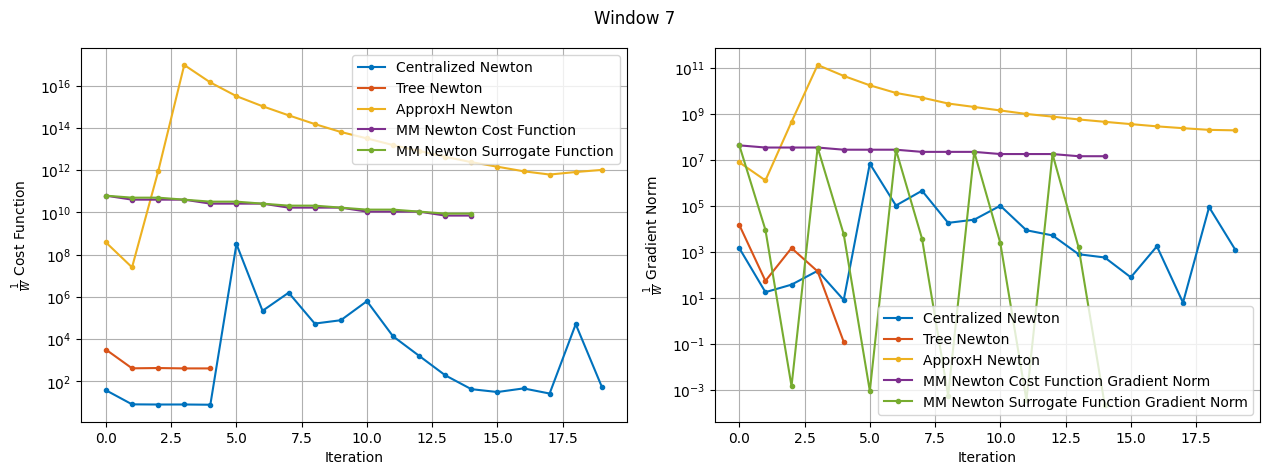


Windows:  50%|█████     | 3/6 [00:10<00:10,  3.46s/it]

-------- Centralized Newton ---------------- Tree Newton --------

-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 664606755403.3345
Gradient norm: 137365058.99895787
Global relative error: 972592.842020314
Position relative errors: 9492.613887326219 m, 624566.154679258 m, 408620.85790209414 m, 623494.7242479753 m

Before applying the algorithm
Cost function: 577.7393929252243
Gradient norm: 5523.332452003782
Global relative error: 2628.3096575598247
Position relative errors: 0.039909368730317515 m, 531.1632694976183 m, 1832.3018763915913 m, 1807.904406485772 m

Before applying the algorithm
L_norm = 133.95651464279413
Grad_L_norm = 3105.361621676225

Iteration 1
Cost function: 67.81227675463863 (-88.26%)
Gradient norm: 205.06773822490467 (-96.29%)
Global relative error: 2639.285022815857 (0.42%)
Iteration 1
Cost function: 723801143187.1372 (8.91%)
Gradient norm: 108104140.36438456 (-21.30%)
Global relative error: 1188869.1415469903 (22.24%)Position relati

/home/vican/g/SpaceSim-Toolkit/src/approxh_newton.py:421: LinAlgWarning: Ill-conditioned matrix (rcond=5.76839e-24): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 8
Cost function: 46.790553782787924 (0.34%)
Gradient norm: 105.1930459141006 (4427.00%)
Global relative error: 2714.4196435694116 (-0.26%)
Position relative errors: 0.07159592563645412 m, 571.3472087334411 m, 1891.4135895205286 m, 1861.2255578672543 m

Iteration 8
L_norm = 6.91307597414715
Grad_L_norm = 98.84816321215116

Iteration 8
Cost function: 3.189308761635995e+22 (-74.93%)
Gradient norm: 65516965545861.35 (-100.00%)
Global relative error: 113023501339.48653 (2432686.56%)
Position relative errors: 671875482.4290586 m, 103863341622.02437 m, 43068739971.180244 m, 11422858293.168056 m

STOP on Iteration 9
Cost function = 46.611243837302744 (-0.38%)
Gradient norm = 0.0659383952848054 (-99.94%)
Global relative error = 2714.1018827749385 (-0.01%)
Final position relative errors: 0.0715959257169153 m, 569.8356567737319 m, 1891.4135895193003 m, 1861.225557868237 m

-------- MM Newton --------

Majorization-Minimization Iteration 1
STOP on Iteration 9
L_norm = 6.838161642224927
G

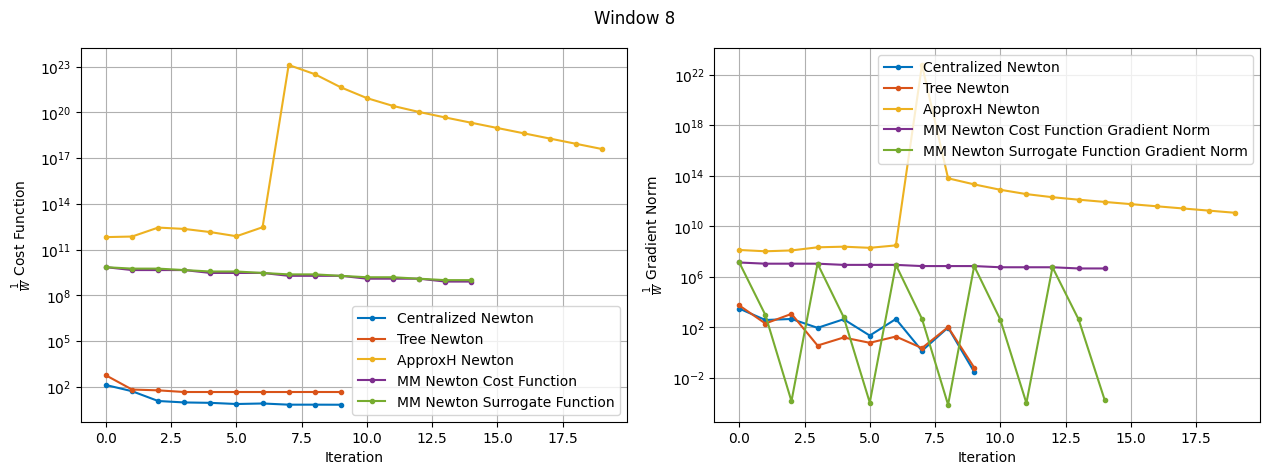


Windows:  67%|██████▋   | 4/6 [00:14<00:06,  3.42s/it]

-------- Centralized Newton ---------------- Tree Newton --------

-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 35.61625274453551
Gradient norm: 946.2344902512024
Global relative error: 2878.6652724589426
Position relative errors: 0.06315927876699182 m, 512.2904444530561 m, 1994.9300440317988 m, 2011.093719368742 m

Before applying the algorithm
Cost function: 7.218982127077038e+17
Gradient norm: 171201817169.0552
Global relative error: 377908109.9358226
Position relative errors: 6360661.124334845 m, 217750367.15732336 m, 218384613.94740444 m, 218197298.07440978 m

Before applying the algorithm
L_norm = 70.43180968674726
Grad_L_norm = 2731.872416547619

Iteration 1
Cost function: 14.879954147015928 (-58.22%)
Gradient norm: 6.746292991610514 (-99.29%)
Global relative error: 2870.333355586649 (-0.29%)
Position relative errors: 0.1660168300427184 m, 503.2254878873821 m, 1989.2217618127233 m, 2007.1238608206297 m

Iteration 1
Cost function: 3.26954068162100

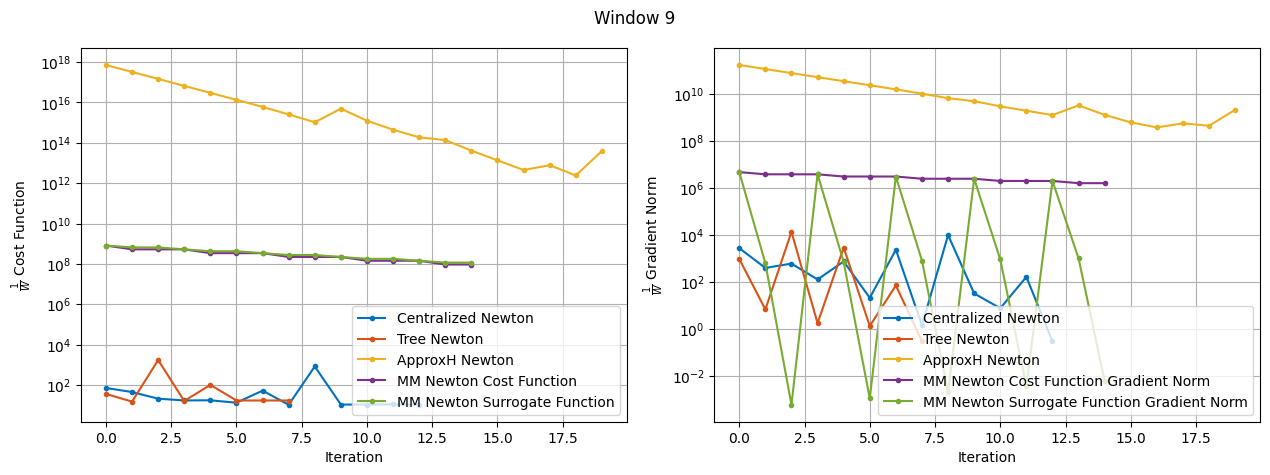


Windows:  83%|████████▎ | 5/6 [00:17<00:03,  3.36s/it]

-------- Centralized Newton ---------------- Tree Newton --------

-------- ApproxH Newton --------
Before applying the algorithm
Cost function: 76906639758290.95
Gradient norm: 3127600902.3591375
Global relative error: 1438102.9664210998
Position relative errors: 22458.669755909876 m, 364959.6263027121 m, 979700.2488489471 m, 985608.546307422 m

Before applying the algorithm
Cost function: 221.0783853048769
Gradient norm: 4336.209200062947
Global relative error: 3333.514951146808
Position relative errors: 0.11438604313731085 m, 549.0952384233088 m, 2291.5764493039724 m, 2357.851230576753 m

Before applying the algorithm
L_norm = 78.1071534236382
Grad_L_norm = 2368.190860336074

Iteration 1
Cost function: 17626384489478.73 (-77.08%)
Gradient norm: 1217836191.8016453 (-61.06%)
Global relative error: 916574.7031174272 (-36.27%)
Position relative errors: 15096.943230926794 m, 655810.3854930798 m, 453113.70995836606 m, 450990.1525289702 m

Iteration 1
Cost function: 82.51915086074962 (-62.

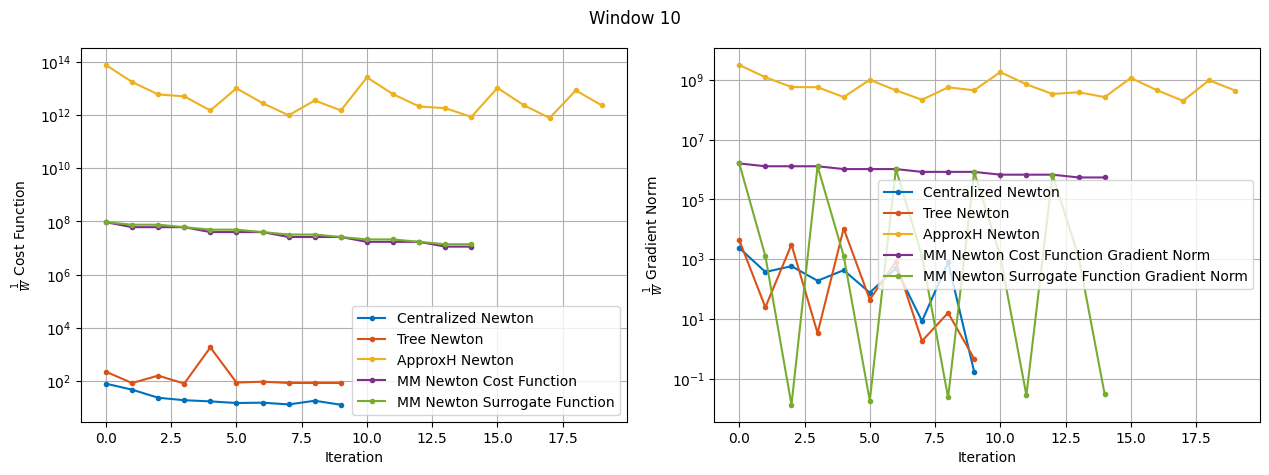


MC runs: 100%|██████████| 1/1 [00:20<00:00, 20.81s/it]


In [417]:
# DISTRIBUTED OVER SEVERAL CPUs

# Initialize storage arrays for state estimates
X_est_unkkt_history = X_est  # Centralized Newton
X_est_tree_newton_history = X_est  # Tree Newton
X_est_approx_newton_history = X_est  # ApproxH Newton
X_est_mm_history = X_est  # MM Newton

def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
    """
    Solves the estimation problem for a given algorithm.
    Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
    """
    print(f"-------- {algorithm_name} --------")
    
    if algorithm_name == "Centralized Newton":
        X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1])
        final_errors = [
            np.linalg.norm(X_true[:3, :, n - W + 1] - X_est[:3]),
            np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est[6:9]),
            np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est[12:15]),
            np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est[18:21])
        ]
        print(f"Final position relative errors: {final_errors} m")
    
    elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
        X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])

    # Collect cost function and gradient norm data
    return (
        algorithm_name,
        X_est,
        algorithm.cost_function_values.copy(),
        algorithm.grad_norm_values.copy(),
        algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
        algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
    )

# ================= MAIN EXECUTION =================
for m in tqdm(range(M), desc="MC runs", leave=True):
    # Generate observations
    Y = np.zeros((9, 1, T))
    for t in range(T):
        Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

    # Initialize state estimates
    X_est_unkkt = X_est[:, :, W - 1]
    X_est_tree_newton = X_est[:, :, W - 1]
    X_est_approx_newton = X_est[:, :, W - 1]
    X_est_mm = X_est[:, :, W - 1]

    for n in tqdm(range(W - 1, K), desc="Windows", leave=False):
        with ProcessPoolExecutor(max_workers=3) as executor:
            # Run each algorithm in parallel
            future_to_algorithm = {
                executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
            }

            # Retrieve results in the main process
            results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}

        # Extract updated estimates
        X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
        X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
        X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
        X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
        
        # Store X_est history per algorithm
        X_est_unkkt_history[:, :, n] = X_est_unkkt
        X_est_tree_newton_history[:, :, n] = X_est_tree_newton
        X_est_approx_newton_history[:, :, n] = X_est_approx_newton
        X_est_mm_history[:, :, n] = X_est_mm
        
        # Propagate the estimated initial conditions until the end of the finite-horizon window
        for i in range(W):
            X_est_unkkt_history[:, :, n] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_history[:, :, n])
            X_est_tree_newton_history[:, :, n] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_history[:, :, n])
            X_est_approx_newton_history[:, :, n] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_history[:, :, n])
            X_est_mm_history[:, :, n] = mm_newton.dynamic_model.x_new(dt, X_est_mm_history[:, :, n])

        # Plot results **in the main process**
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

        # Cost function values
        ax1.plot(cost_unkkt, '.-', label='Centralized Newton')
        ax1.plot(cost_tree, '.-', label='Tree Newton')
        ax1.plot(cost_approx, '.-', label='ApproxH Newton')
        ax1.plot(cost_mm, '.-', label='MM Newton Cost Function')
        ax1.plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
        ax1.set_xlabel('Iteration')
        ax1.set_ylabel(r'$\frac{1}{W}$ Cost Function')
        ax1.set_yscale('log')
        ax1.grid(True)
        ax1.legend()

        # Gradient norm values
        ax2.plot(grad_unkkt, '.-', label='Centralized Newton')
        ax2.plot(grad_tree, '.-', label='Tree Newton')
        ax2.plot(grad_approx, '.-', label='ApproxH Newton')
        ax2.plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
        ax2.plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel(r'$\frac{1}{W}$ Gradient Norm')
        ax2.set_yscale('log')
        ax2.grid(True)
        ax2.legend()

        fig.suptitle(f'Window {n + 1}')
        plt.tight_layout()
        plt.show()

        # Update state estimates
        X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
        X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
        X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
        X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

In [418]:
if not use_several_cpus:
    # SEQUENTIAL USING ONE CPU
    # Main execution loop
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

        # Estimate the state
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False): # n is the index of the end of the finite-horizon window
            print("-------- Centralized Newton --------")
            X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n - W + 1 : n + 1])
            print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n - W + 1] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est_unkkt[18:21])} m")
            print("-------- Tree Newton --------")
            X_est_tree_newton = tree_newton.solve_for_each_window(dt, X_est_tree_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- ApproxH Newton --------")
            X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- MM Newton --------")
            X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

            # First subplot - Cost function values
            ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
            ax1.plot(tree_newton.cost_function_values, '.-', label='Tree Newton')
            ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
            ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
            ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('$\frac{1}{W}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()

            # Second subplot - Gradient norm values
            ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
            ax2.plot(tree_newton.grad_norm_values, '.-', label='Tree Newton')
            ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
            ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('$\frac{1}{W}$Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()

            plt.title(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
            
            unkkt.cost_function_values = []
            unkkt.grad_norm_values = []
            tree_newton.cost_function_values = []
            tree_newton.grad_norm_values = []
            approxh_newton.cost_function_values = []
            approxh_newton.grad_norm_values = []
            mm_newton.cost_function_values = []
            mm_newton.grad_norm_values = []
            mm_newton.surrogate_function_values = []
            mm_newton.surrogate_grad_norm_values = []
            
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

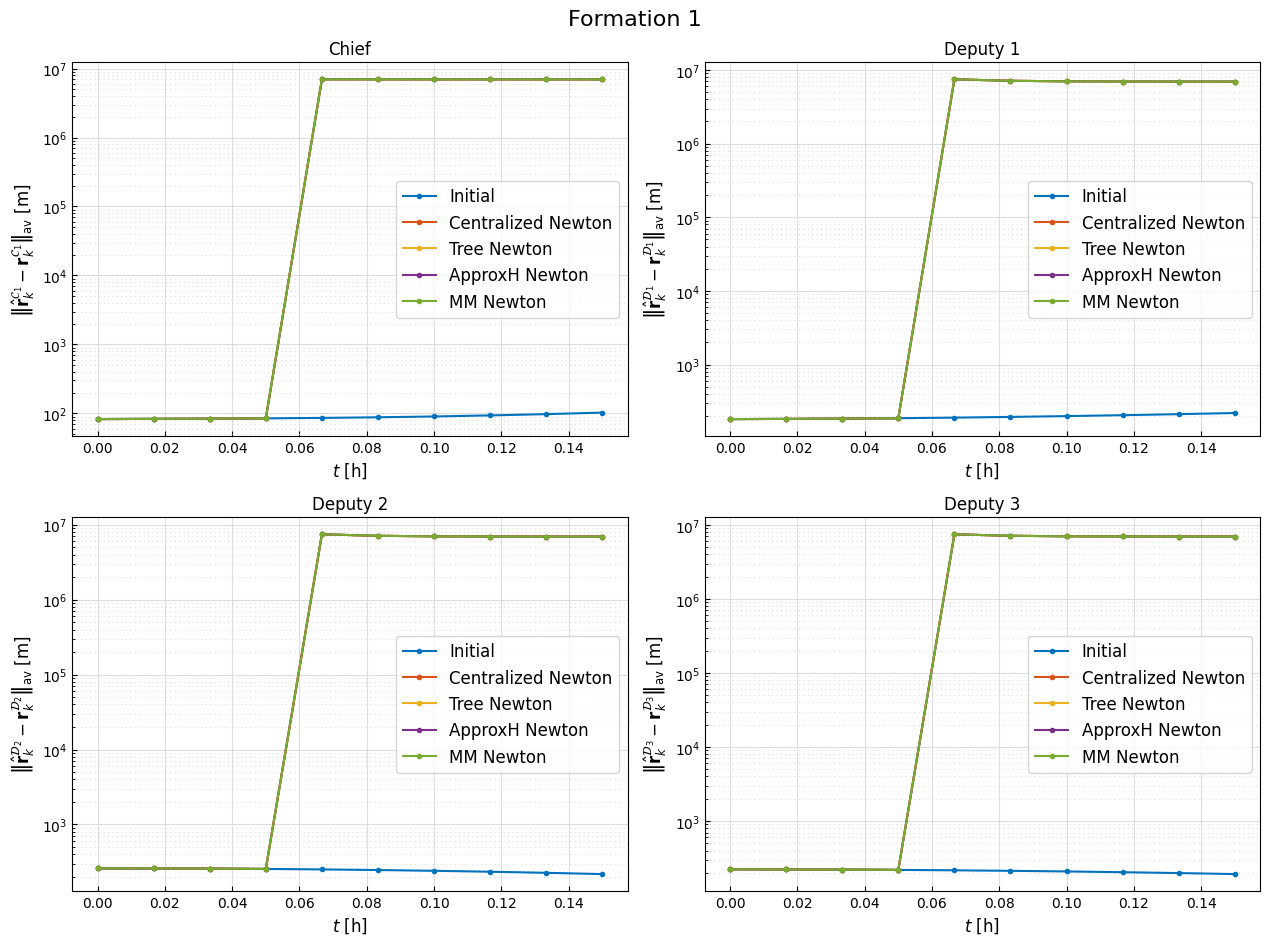

In [419]:
# Compute norm of absolute position deviation for each agent and each algorithm
def compute_position_deviation(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

# Extract deviations for Chief and Deputies
dev_chief_unkkt, dev_deputy1_unkkt, dev_deputy2_unkkt, dev_deputy3_unkkt = compute_position_deviation(X_est_unkkt_history, X_true)
dev_chief_tree, dev_deputy1_tree, dev_deputy2_tree, dev_deputy3_tree = compute_position_deviation(X_est_tree_newton_history, X_true)
dev_chief_approx, dev_deputy1_approx, dev_deputy2_approx, dev_deputy3_approx = compute_position_deviation(X_est_approx_newton_history, X_true)
dev_chief_mm, dev_deputy1_mm, dev_deputy2_mm, dev_deputy3_mm = compute_position_deviation(X_est_mm_history, X_true)

# Time array
T = X_true.shape[2]

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time, dev_chief_unkkt, ".-", label="Centralized Newton")
axs[0, 0].plot(time, dev_chief_tree, ".-", label="Tree Newton")
axs[0, 0].plot(time, dev_chief_approx, ".-", label="ApproxH Newton")
axs[0, 0].plot(time, dev_chief_mm, ".-", label="MM Newton")
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time, dev_deputy1_unkkt, ".-", label="Centralized Newton")
axs[0, 1].plot(time, dev_deputy1_tree, ".-", label="Tree Newton")
axs[0, 1].plot(time, dev_deputy1_approx, ".-", label="ApproxH Newton")
axs[0, 1].plot(time, dev_deputy1_mm, ".-", label="MM Newton")
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time, dev_deputy2_unkkt, ".-", label="Centralized Newton")
axs[1, 0].plot(time, dev_deputy2_tree, ".-", label="Tree Newton")
axs[1, 0].plot(time, dev_deputy2_approx, ".-", label="ApproxH Newton")
axs[1, 0].plot(time, dev_deputy2_mm, ".-", label="MM Newton")
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time, dev_deputy3_unkkt, ".-", label="Centralized Newton")
axs[1, 1].plot(time, dev_deputy3_tree, ".-", label="Tree Newton")
axs[1, 1].plot(time, dev_deputy3_approx, ".-", label="ApproxH Newton")
axs[1, 1].plot(time, dev_deputy3_mm, ".-", label="MM Newton")
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()